**This code is for learning $F_a$ of Crazyfile 2.0 using the deep sets, for datacollection 19** 

**The goal is to learn $F_a$ in heterogeneous case**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import signal
from random import shuffle

In [6]:
# Convert quaternion to rotation matrix
def rotation_matrix(quat):
    rot_mat = np.ones([3,3])
    a = quat[0]**2
    b = quat[1]**2
    c = quat[2]**2
    d = quat[3]**2
    e = quat[0]*quat[1]
    f = quat[0]*quat[2]
    g = quat[0]*quat[3]
    h = quat[1]*quat[2]
    i = quat[1]*quat[3]
    j = quat[2]*quat[3]
    rot_mat[0,0] = a - b - c + d
    rot_mat[0,1] = 2 * (e - j)
    rot_mat[0,2] = 2 * (f + i)
    rot_mat[1,0] = 2 * (e + j)
    rot_mat[1,1] = -a + b - c + d
    rot_mat[1,2] = 2 * (h - g)
    rot_mat[2,0] = 2 * (f - i)
    rot_mat[2,1] = 2 * (h + g)
    rot_mat[2,2] = -a - b + c + d
     
    return rot_mat

In [7]:
# Convert quaternion to Euler angle
def qua2euler(qua):
    euler = np.zeros(3)
    q0 = qua[3]
    q1 = qua[0]
    q2 = qua[1]
    q3 = qua[2]
    euler[0] = np.degrees(np.arctan2(2*(q0*q1+q2*q3), 1-2*(q1**2+q2**2)))
    euler[1] = np.degrees(np.arcsin(2*(q0*q2-q3*q1)))
    euler[2] = np.degrees(np.arctan2(2*(q0*q3+q1*q2), 1-2*(q2**2+q3**2)))
    return euler

# Preprocessing data

In [8]:
def data_extraction(filename):    
    raw = pd.read_csv(filename)
    secs = np.copy(raw.iloc[:, 0])
    bias = np.copy(secs[0])
    time = (secs - bias) / 1e6
    pos = np.copy(raw.iloc[:, 1:4])
    vel = np.copy(raw.iloc[:, 4:7])
    acc = np.copy(raw.iloc[:, 7:10])
    qua = np.copy(raw.iloc[:, 10:14])
    thr = np.copy(raw.iloc[:, 14:18])
    pwm = np.copy(raw.iloc[:, 18:22])
    vol = np.copy(raw.iloc[:, 22]) / 4.2
    thr_des = np.copy(raw.iloc[:, 23])
    tau_u = np.copy(raw.iloc[:, 24:27])
    omega = np.copy(raw.iloc[:, 27:])
    
    Data = {'time': time, 'pos': pos, 'vel': vel, 'acc': acc, 'qua': qua, 'thr': thr, \
            'pwm': pwm, 'vol': vol, 'thr_des': thr_des, 'tau_u': tau_u, 'omega': omega}
    
    return Data

**Visualization**

In [9]:
def vis(Data1, Data2, ss1, ee1, ss2, ee2):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1)
    line1, = plt.plot(Data1['time'][ss1:ee1], Data1['pos'][ss1:ee1, 0])
    line2, = plt.plot(Data1['time'][ss1:ee1], Data1['pos'][ss1:ee1, 1])
    line3, = plt.plot(Data1['time'][ss1:ee1], Data1['pos'][ss1:ee1, 2])
    plt.legend([line1, line2, line3], ['x', 'y', 'z'])
    plt.grid()
    plt.title('traj (agent a)')
    plt.subplot(1, 3, 2)
    line1, = plt.plot(Data2['time'][ss2:ee2], Data2['pos'][ss2:ee2, 0])
    line2, = plt.plot(Data2['time'][ss2:ee2], Data2['pos'][ss2:ee2, 1])
    line3, = plt.plot(Data2['time'][ss2:ee2], Data2['pos'][ss2:ee2, 2])
    plt.legend([line1, line2, line3], ['x', 'y', 'z'])
    plt.grid()
    plt.title('traj (agent b)')
    plt.subplot(1, 3, 3)
    plt.scatter(Data1['pos'][ss1:ee1, 1], Data1['pos'][ss1:ee1, 2])
    plt.scatter(Data2['pos'][ss2:ee2, 1], Data2['pos'][ss2:ee2, 2])
    plt.legend(['a', 'b'])
    plt.show()
    print("a: t0, t1 = " + str(Data1['time'][ss1]) + ', ' + str(Data1['time'][ee1]))
    print("b: t0, t1 = " + str(Data2['time'][ss2]) + ', ' + str(Data2['time'][ee2]))

In [10]:
# Note that all these cfs are with new IMU

# L-L random walk; cf101 & cf102; total: 127.55s
# ./random_walk_large_large/
# 00     01
# 63.73s 63.82s

# L-S random walk; cf102 & cf50; total: 127.18s
# ./random_walk_large_small/
# 02     03
# 63.74s 63.44s

# S-S random walk; cf50 & cf51; total: 127.45s
# ./random_walk_small_small/
# 04     05
# 63.62s 63.83s

# L-L swap; cf101 & cf102; total: 59.77s
# ./swap_large_large/
# 02
# 59.77s 

# S-S swap; cf50 & cf51; total: 59.92s
# ./swap_small_small/
# 02
# 59.92s

# L-S swap; cf102 & cf50; total: 119.59s
# ./swap_large_small/
# 00(LS) 01(SL)
# 59.79s 59.80s

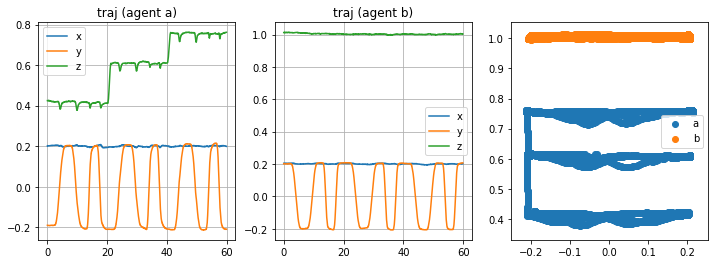

a: t0, t1 = 0.0, 59.815671
b: t0, t1 = 0.0, 59.814418


In [11]:
Data_a = data_extraction('./swap_large_small/cf102_01.csv')
Data_b = data_extraction('./swap_large_small/cf50_01.csv')
vis(Data_a, Data_b, 0, -1, 0, -1)

**Interpolation**

In [12]:
from scipy import interpolate
from scipy.interpolate import interp1d

In [13]:
# cubic (or linear) interpolation
def cubic(x, y, xnew, kind='linear'):
    f = interp1d(x, y, kind=kind)
    return f(xnew)
    
def interpolation_cubic(t0, t1, Data, ss, ee):
    time = np.linspace(t0, t1, 100 * (t1 - t0) + 1)
    pos = np.zeros((time.shape[0], 3))
    qua = np.zeros((time.shape[0], 4))
    pwm = np.zeros((time.shape[0], 4))
    vel = np.zeros((time.shape[0], 3))
    vel_num = np.zeros((time.shape[0], 3))
    acc_num = np.zeros((time.shape[0], 3))
    vol = np.zeros((time.shape[0]))
    acc_imu = np.zeros((time.shape[0], 3))
    tau_u = np.zeros((time.shape[0], 3))
    omega = np.zeros((time.shape[0], 3))
    omega_dot = np.zeros((time.shape[0], 3))
    euler = np.zeros((time.shape[0], 3))
    acc_filter = np.zeros((time.shape[0], 3))
    acc_smooth = np.zeros((time.shape[0], 3))
    
    x = Data['time'][ss:ee]
    for i in range(3):
        pos[:, i] = cubic(x, Data['pos'][ss:ee, i], time)
        vel[:, i] = cubic(x, Data['vel'][ss:ee, i], time)
        acc_imu[:, i] = cubic(x, Data['acc'][ss:ee, i], time)
        tau_u[:, i] = cubic(x, Data['tau_u'][ss:ee, i], time)
        omega[:, i] = cubic(x, Data['omega'][ss:ee, i], time)
 
    for i in range(3):
        acc_num[2:-2,i] = (-vel[4:,i] + 8 * vel[3:-1,i] - 8 * vel[1:-3,i] + vel[:-4,i]) / 12 * 100
        vel_num[2:-2,i] = (-pos[4:,i] + 8 * pos[3:-1,i] - 8 * pos[1:-3,i] + pos[:-4,i]) / 12 * 100        
        omega_dot[2:-2,i] = (-omega[4:,i] + 8 * omega[3:-1,i] - 8 * omega[1:-3,i] + omega[:-4,i]) / 12 * 100
    
    for i in range(4):
        qua[:, i] = cubic(x, Data['qua'][ss:ee, i], time)
        pwm[:, i] = cubic(x, Data['pwm'][ss:ee, i], time)
    vol[:] = cubic(x, Data['vol'][ss:ee], time)
    
    for j in range(time.shape[0]):
        euler[j, :] = qua2euler(qua[j, :])
    
    # Filter on acc
    b, a = signal.butter(1, 0.1)
    for i in range(3):
        acc_filter[:, i] = signal.filtfilt(b, a, acc_num[:, i])
    
    # Moving average smoothing
    n = 5
    l = int((n-1) / 2)
    for i in range(3):
        for j in range(n):
            if j == n-1:
                temp = acc_num[j:, i]
            else:
                temp = acc_num[j:-(n-1-j), i]
            acc_smooth[l:-l, i] = acc_smooth[l:-l, i] + temp
        acc_smooth[l:-l, i] = acc_smooth[l:-l, i] / n
        
    Data_int = {'time': time, 'pos': pos, 'vel': vel, 'acc_imu': acc_imu, 'vel_num': vel_num, \
                'qua': qua, 'pwm': pwm, 'vol': vol, 'acc_num': acc_num, 'euler': euler, \
               'tau_u': tau_u, 'omega': omega, 'omega_dot': omega_dot, 'acc_filter': acc_filter, 'acc_smooth': acc_smooth}
    return Data_int

In [57]:
# L-L random walk; cf101 & cf102; total: 127.55s
# ./random_walk_large_large/
# 00     01
# 63.73s 63.82s

# L-S random walk; cf102 & cf50; total: 127.18s
# ./random_walk_large_small/
# 02     03
# 63.74s 63.44s

# S-S random walk; cf50 & cf51; total: 127.45s
# ./random_walk_small_small/
# 04     05
# 63.62s 63.83s

# L-L swap; cf101 & cf102; total: 59.77s
# ./swap_large_large/
# 02
# 59.77s 

# S-S swap; cf50 & cf51; total: 59.92s
# ./swap_small_small/
# 02
# 59.92s

# L-S swap; cf102 & cf50; total: 119.59s
# ./swap_large_small/
# 00(LS) 01(SL)
# 59.79s 59.80s

Data_SS_S1_list = []
Data_SS_S2_list = []
Data_LL_L1_list = []
Data_LL_L2_list = []
Data_LS_L_list = []
Data_LS_S_list = []

# L-L random walk; cf101 & cf102; total: 127.55s
# ./random_walk_large_large/
# 00     01
# 63.73s 63.82s
TF = np.array([63.73, 63.82])
S = ['00', '01']
name = './random_walk_large_large/'
for i in range(len(TF)):
    Data_LL_L1_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf101_'+S[i]+'.csv'), ss=0, ee=-1))
    Data_LL_L2_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf102_'+S[i]+'.csv'), ss=0, ee=-1))

# L-S random walk; cf102 & cf50; total: 127.18s
# ./random_walk_large_small/
# 02     03
# 63.74s 63.44s
TF = np.array([63.74, 63.44])
S = ['02', '03']
name = './random_walk_large_small/'
for i in range(len(TF)):
    Data_LS_L_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf102_'+S[i]+'.csv'), ss=0, ee=-1))
    Data_LS_S_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf50_'+S[i]+'.csv'), ss=0, ee=-1))

# S-S random walk; cf50 & cf51; total: 127.45s
# ./random_walk_small_small/
# 04     05
# 63.62s 63.83s
TF = np.array([63.62, 63.83])
S = ['04', '05']
name = './random_walk_small_small/'
for i in range(len(TF)):
    Data_SS_S1_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf50_'+S[i]+'.csv'), ss=0, ee=-1))
    Data_SS_S2_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf51_'+S[i]+'.csv'), ss=0, ee=-1))
    
# L-L swap; cf101 & cf102; total: 59.77s
# ./swap_large_large/
# 02
# 59.77s 
TF = np.array([59.77])
S = ['02']
name = './swap_large_large/'
for i in range(len(TF)):
    Data_LL_L1_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf101_'+S[i]+'.csv'), ss=0, ee=-1))
    Data_LL_L2_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf102_'+S[i]+'.csv'), ss=0, ee=-1))

# S-S swap; cf50 & cf51; total: 59.92s
# ./swap_small_small/
# 02
# 59.92s
TF = np.array([59.92])
S = ['02']
name = './swap_small_small/'
for i in range(len(TF)):
    Data_SS_S1_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf50_'+S[i]+'.csv'), ss=0, ee=-1))
    Data_SS_S2_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf51_'+S[i]+'.csv'), ss=0, ee=-1))

# L-S swap; cf102 & cf50; total: 119.59s
# ./swap_large_small/
# 00(LS) 01(SL)
# 59.79s 59.80s
TF = np.array([59.79, 59.80])
S = ['00', '01']
name = './swap_large_small/'
for i in range(len(TF)):
    Data_LS_L_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf102_'+S[i]+'.csv'), ss=0, ee=-1))
    Data_LS_S_list.append(interpolation_cubic(0, TF[i], data_extraction(name+'cf50_'+S[i]+'.csv'), ss=0, ee=-1))

**Data merge**

In [59]:
def merge(Data1, Data2):
    Data = {'time': np.concatenate((Data1['time'], Data2['time'] + Data1['time'][-1] + 0.01))}
    for topic in Data1:
        if topic != 'time':
            Data[topic] = np.concatenate((Data1[topic], Data2[topic]))
    return Data

In [71]:
def Merge(Data_14_list):
    if len(Data_14_list) == 1:
        return Data_14_list[0]
    Data_14 = merge(Data_14_list[0], Data_14_list[1])
    if len(Data_14_list) > 2:
        for i in range(2, len(Data_14_list)):
            Data_14 = merge(Data_14, Data_14_list[i])
    return Data_14

In [72]:
Data_LL_L1 = Merge(Data_LL_L1_list)
Data_LL_L2 = Merge(Data_LL_L2_list)
Data_SS_S1 = Merge(Data_SS_S1_list)
Data_SS_S2 = Merge(Data_SS_S2_list)
Data_LS_L = Merge(Data_LS_L_list)
Data_LS_S = Merge(Data_LS_S_list)

# Only train on random walk data
Data_LL_L1 = Merge(Data_LL_L1_list[:2])
Data_LL_L2 = Merge(Data_LL_L2_list[:2])
Data_SS_S1 = Merge(Data_SS_S1_list[:2])
Data_SS_S2 = Merge(Data_SS_S2_list[:2])
Data_LS_L = Merge(Data_LS_L_list[:2])
Data_LS_S = Merge(Data_LS_S_list[:2])

# Validation data (swap)
Data_SS_S1_val = Merge(Data_SS_S1_list[2:])
Data_SS_S2_val = Merge(Data_SS_S2_list[2:])
Data_LL_L1_val = Merge(Data_LL_L1_list[2:])
Data_LL_L2_val = Merge(Data_LL_L2_list[2:])
Data_LS_L_val = Merge(Data_LS_L_list[2:])
Data_LS_S_val = Merge(Data_LS_S_list[2:])

# Get $F_a$ and $\tau_a$ data

**Get Fa from new system id and numerical diff**

In [73]:
def Fa(Data, m, g, p_00, p_10, p_01, p_20, p_11):
    R = np.zeros([Data['time'].shape[0], 3, 3])
    for i in range(Data['time'].shape[0]):
        R[i, :, :] = rotation_matrix(Data['qua'][i, :])
        
    force_pwm_1 = p_00 + p_10 * Data['pwm'][:, 0] + p_01 * Data['vol'] + p_20 * Data['pwm'][:, 0]**2 + p_11 * Data['vol'] * Data['pwm'][:, 0]
    force_pwm_2 = p_00 + p_10 * Data['pwm'][:, 1] + p_01 * Data['vol'] + p_20 * Data['pwm'][:, 1]**2 + p_11 * Data['vol'] * Data['pwm'][:, 1]
    force_pwm_3 = p_00 + p_10 * Data['pwm'][:, 2] + p_01 * Data['vol'] + p_20 * Data['pwm'][:, 2]**2 + p_11 * Data['vol'] * Data['pwm'][:, 2]
    force_pwm_4 = p_00 + p_10 * Data['pwm'][:, 3] + p_01 * Data['vol'] + p_20 * Data['pwm'][:, 3]**2 + p_11 * Data['vol'] * Data['pwm'][:, 3]
    thrust_pwm = force_pwm_1 + force_pwm_2 + force_pwm_3 + force_pwm_4 # gram
    
    Fa = np.zeros([Data['time'].shape[0], 3])
    Fa_num = np.zeros([Data['time'].shape[0], 3])
    Fa_filter = np.zeros([Data['time'].shape[0], 3])
    Fa_smooth = np.zeros([Data['time'].shape[0], 3])
    force_world = np.zeros([Data['time'].shape[0], 3])
    for i in range(Data['time'].shape[0]):
        Fa[i, :] = m * Data['acc_imu'][i, :] / 1000 - thrust_pwm[i] / 1000 * g * R[i, :, 2] # Newton
        Fa_num[i, :] = m * np.array([0, 0, g]) / 1000 + m * Data['acc_num'][i, :] / 1000 - thrust_pwm[i] / 1000 * g * R[i, :, 2] # Newton
        Fa_filter[i, :] = m * np.array([0, 0, g]) / 1000 + m * Data['acc_filter'][i, :] / 1000 - thrust_pwm[i] / 1000 * g * R[i, :, 2] # Newton
        Fa_smooth[i, :] = m * np.array([0, 0, g]) / 1000 + m * Data['acc_smooth'][i, :] / 1000 - thrust_pwm[i] / 1000 * g * R[i, :, 2] # Newton
        force_world[i, :] = thrust_pwm[i] / 1000 * g * R[i, :, 2] # Newton
    
    Data['fa_imu'] = Fa
    Data['fa_num'] = Fa_num
    Data['fa_filter'] = Fa_filter
    Data['fa_smooth'] = Fa_smooth
    
    return Data

In [74]:
m = 67
g = 9.81
C_00 = 44.10386631845999
C_10 = -122.51151800146272
C_01 = -36.18484254283743
C_20 = 53.10772568607133
C_11 = 107.6819263349139
Data_LL_L1 = Fa(Data_LL_L1, m, g, C_00, C_10, C_01, C_20, C_11)
Data_LL_L2 = Fa(Data_LL_L2, m, g, C_00, C_10, C_01, C_20, C_11)
Data_LS_L = Fa(Data_LS_L, m, g, C_00, C_10, C_01, C_20, C_11)
Data_LL_L1_val = Fa(Data_LL_L1_val, m, g, C_00, C_10, C_01, C_20, C_11)
Data_LL_L2_val = Fa(Data_LL_L2_val, m, g, C_00, C_10, C_01, C_20, C_11)
Data_LS_L_val = Fa(Data_LS_L_val, m, g, C_00, C_10, C_01, C_20, C_11)

m = 32
g = 9.81
C_00 = 11.093358483549203
C_10 = -39.08104165843915
C_01 = -9.525647087583181
C_20 = 20.573302305476638
C_11 = 38.42885066644033
Data_SS_S1 = Fa(Data_SS_S1, m, g, C_00, C_10, C_01, C_20, C_11)
Data_SS_S2 = Fa(Data_SS_S2, m, g, C_00, C_10, C_01, C_20, C_11)
Data_LS_S = Fa(Data_LS_S, m, g, C_00, C_10, C_01, C_20, C_11)
Data_SS_S1_val = Fa(Data_SS_S1_val, m, g, C_00, C_10, C_01, C_20, C_11)
Data_SS_S2_val = Fa(Data_SS_S2_val, m, g, C_00, C_10, C_01, C_20, C_11)
Data_LS_S_val = Fa(Data_LS_S_val, m, g, C_00, C_10, C_01, C_20, C_11)

# Visualization: statistics of $F_a$

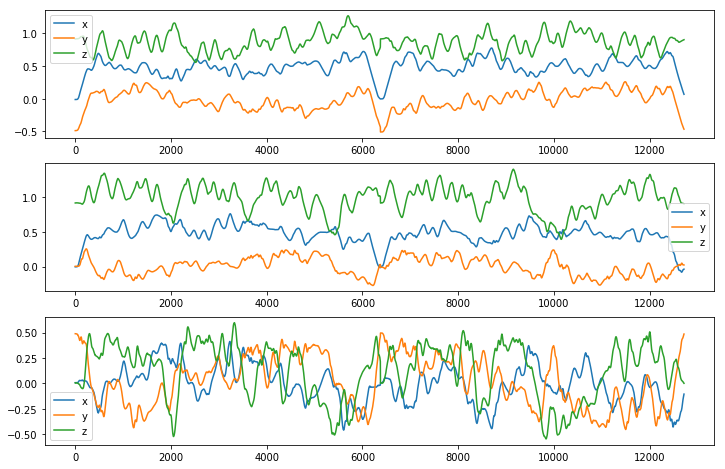

In [75]:
ss = 0
ee = -1
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(Data_LS_L['pos'][ss:ee, :])
plt.legend(['x', 'y', 'z'])
plt.subplot(3, 1, 2)
plt.plot(Data_LS_S['pos'][ss:ee, :])
plt.legend(['x', 'y', 'z'])
plt.subplot(3, 1, 3)
plt.plot(Data_LS_S['pos'][ss:ee, :] - Data_LS_L['pos'][ss:ee, :])
plt.legend(['x', 'y', 'z'])
plt.show()

# Learn $F_a$: Deep Sets!

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
torch.multiprocessing.set_sharing_strategy('file_system')

**Data normalization**

In [77]:
def get_data(D1, D2, s):
    typ = 'fa_imu'
    g = 9.81
    L = D1['time'].shape[0]
    data_input = np.zeros([L, 7])
    data_output = np.zeros([L, 3])
    data_input[:, :3] = D2['pos'] - D1['pos']
    data_input[:, 3:6] = D2['vel'] - D1['vel']
    data_input[:, 6] = s
    data_output[:, :] = D1[typ] / g * 1000 # gram
    
    print(data_input.shape, data_output.shape)
    
    return data_input, data_output

In [78]:
data_input_L2L_a, data_output_L2L_a = get_data(D1=Data_LL_L1, D2=Data_LL_L2, s=0)
data_input_L2L_b, data_output_L2L_b = get_data(D1=Data_LL_L2, D2=Data_LL_L1, s=0)
data_input_L2L = np.vstack((data_input_L2L_a, data_input_L2L_b))
data_output_L2L = np.vstack((data_output_L2L_a, data_output_L2L_b))
print(data_input_L2L.shape, data_output_L2L.shape)

# Validation
data_input_L2L_a, data_output_L2L_a = get_data(D1=Data_LL_L1_val, D2=Data_LL_L2_val, s=0)
data_input_L2L_b, data_output_L2L_b = get_data(D1=Data_LL_L2_val, D2=Data_LL_L1_val, s=0)
data_input_L2L_val = np.vstack((data_input_L2L_a, data_input_L2L_b))
data_output_L2L_val = np.vstack((data_output_L2L_a, data_output_L2L_b))

(12757, 7) (12757, 3)
(12757, 7) (12757, 3)
(25514, 7) (25514, 3)
(5978, 7) (5978, 3)
(5978, 7) (5978, 3)


In [79]:
data_input_S2S_a, data_output_S2S_a = get_data(D1=Data_SS_S1, D2=Data_SS_S2, s=1)
data_input_S2S_b, data_output_S2S_b = get_data(D1=Data_SS_S2, D2=Data_SS_S1, s=1)
data_input_S2S = np.vstack((data_input_S2S_a, data_input_S2S_b))
data_output_S2S = np.vstack((data_output_S2S_a, data_output_S2S_b))
print(data_input_S2S.shape, data_output_S2S.shape)

# Validation
data_input_S2S_a, data_output_S2S_a = get_data(D1=Data_SS_S1_val, D2=Data_SS_S2_val, s=1)
data_input_S2S_b, data_output_S2S_b = get_data(D1=Data_SS_S2_val, D2=Data_SS_S1_val, s=1)
data_input_S2S_val = np.vstack((data_input_S2S_a, data_input_S2S_b))
data_output_S2S_val = np.vstack((data_output_S2S_a, data_output_S2S_b))

(12747, 7) (12747, 3)
(12747, 7) (12747, 3)
(25494, 7) (25494, 3)
(5993, 7) (5993, 3)
(5993, 7) (5993, 3)


In [80]:
data_input_L2S, data_output_L2S = get_data(D1=Data_LS_S, D2=Data_LS_L, s=2)
data_input_S2L, data_output_S2L = get_data(D1=Data_LS_L, D2=Data_LS_S, s=3)

# Validation
data_input_L2S_val, data_output_L2S_val = get_data(D1=Data_LS_S_val, D2=Data_LS_L_val, s=2)
data_input_S2L_val, data_output_S2L_val = get_data(D1=Data_LS_L_val, D2=Data_LS_S_val, s=3)

(12720, 7) (12720, 3)
(12720, 7) (12720, 3)
(11961, 7) (11961, 3)
(11961, 7) (11961, 3)


**Data filter**

In [81]:
def hist(data_input, data_output):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 4, 1)
    plt.hist(data_input[:, 0], 50, density=True)
    plt.title('x')
    plt.subplot(1, 4, 2)
    plt.hist(data_input[:, 1], 50, density=True)
    plt.title('y')
    plt.subplot(1, 4, 3)
    plt.hist(data_input[:, 2], 50, density=True)
    plt.title('z')
    plt.subplot(1, 4, 4)
    plt.scatter(data_input[:, 1], data_input[:, 2], s=0.1)
    plt.title('y-z')
    plt.xlabel('y')
    plt.ylabel('z')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.subplot(1, 4, 1)
    plt.hist(data_input[:, 3], 50, density=True)
    plt.title('vx')
    plt.subplot(1, 4, 2)
    plt.hist(data_input[:, 4], 50, density=True)
    plt.title('vy')
    plt.subplot(1, 4, 3)
    plt.hist(data_input[:, 5], 50, density=True)
    plt.title('vz')
    plt.subplot(1, 4, 4)
    plt.scatter(data_input[:, 4], data_input[:, 5], s=0.1)
    plt.title('vy-vz')
    plt.xlabel('vy')
    plt.ylabel('vz')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.subplot(1, 4, 1)
    plt.hist(data_output[:, 0], 50, density=True)
    plt.title('fa_x')
    plt.subplot(1, 4, 2)
    plt.hist(data_output[:, 1], 50, density=True)
    plt.title('fa_y')
    plt.subplot(1, 4, 3)
    plt.hist(data_output[:, 2], 50, density=True)
    plt.title('fa_z')
    plt.tight_layout()
    plt.show()

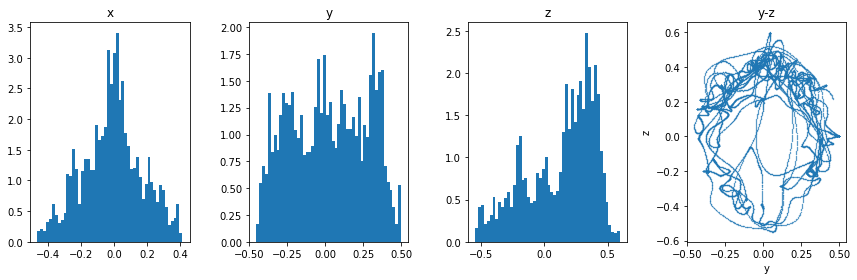

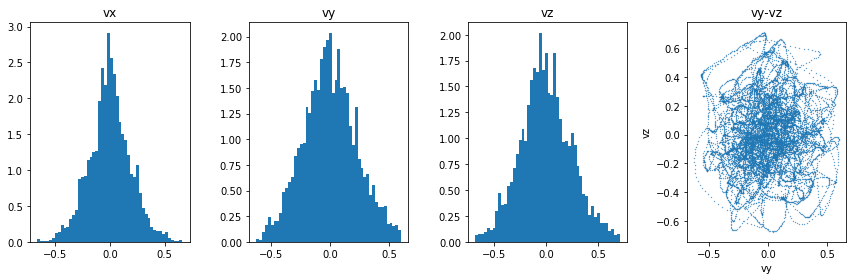

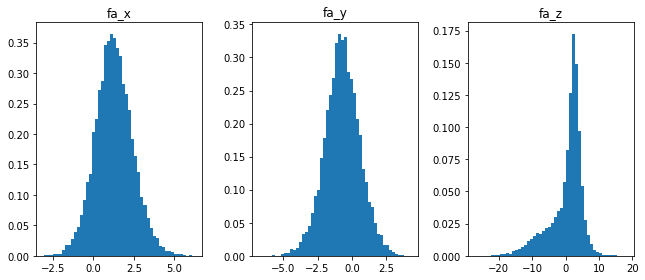

In [82]:
hist(data_input_S2L, data_output_S2L)

**Numpy to torch and data shuffle**

In [83]:
Data_input_L2L = torch.from_numpy(data_input_L2L[:, :])
Data_output_L2L = torch.from_numpy(data_output_L2L[:, 2:])
print(Data_input_L2L.shape, Data_output_L2L.shape)

Data_input_S2S = torch.from_numpy(data_input_S2S[:, :])
Data_output_S2S = torch.from_numpy(data_output_S2S[:, 2:])
print(Data_input_S2S.shape, Data_output_S2S.shape)

Data_input_L2S = torch.from_numpy(data_input_L2S[:, :])
Data_output_L2S = torch.from_numpy(data_output_L2S[:, 2:])
print(Data_input_L2S.shape, Data_output_L2S.shape)

Data_input_S2L = torch.from_numpy(data_input_S2L[:, :])
Data_output_S2L = torch.from_numpy(data_output_S2L[:, 2:])
print(Data_input_S2L.shape, Data_output_S2L.shape)

# Validation
Data_input_L2L_val = torch.from_numpy(data_input_L2L_val[:, :])
Data_output_L2L_val = torch.from_numpy(data_output_L2L_val[:, 2:])

Data_input_S2S_val = torch.from_numpy(data_input_S2S_val[:, :])
Data_output_S2S_val = torch.from_numpy(data_output_S2S_val[:, 2:])

Data_input_L2S_val = torch.from_numpy(data_input_L2S_val[:, :])
Data_output_L2S_val = torch.from_numpy(data_output_L2S_val[:, 2:])

Data_input_S2L_val = torch.from_numpy(data_input_S2L_val[:, :])
Data_output_S2L_val = torch.from_numpy(data_output_S2L_val[:, 2:])

torch.Size([25514, 7]) torch.Size([25514, 1])
torch.Size([25494, 7]) torch.Size([25494, 1])
torch.Size([12720, 7]) torch.Size([12720, 1])
torch.Size([12720, 7]) torch.Size([12720, 1])


In [84]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        Input = self.inputs[idx,]
        output = self.outputs[idx,]
        sample = {'input': Input, 'output': output}

        return sample

In [85]:
def set_generate(Data_input, Data_output):
    trainset = MyDataset(Data_input, Data_output)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    return trainset, trainloader

In [86]:
trainset_L2L, trainloader_L2L = set_generate(Data_input_L2L, Data_output_L2L)
trainset_S2S, trainloader_S2S = set_generate(Data_input_S2S, Data_output_S2S)
trainset_L2S, trainloader_L2S = set_generate(Data_input_L2S, Data_output_L2S)
trainset_S2L, trainloader_S2L = set_generate(Data_input_S2L, Data_output_S2L)

**Neural net and optimization**

In [87]:
class phi_Net(nn.Module):
    def __init__(self):
        super(phi_Net, self).__init__()
        self.fc1 = nn.Linear(6, 25)
        self.fc2 = nn.Linear(25, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 20)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
class rho_Net(nn.Module):
    def __init__(self):
        super(rho_Net, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

phi_L_net = phi_Net()
phi_S_net = phi_Net()
rho_L_net = rho_Net()
rho_S_net = rho_Net()

In [88]:
criterion = nn.MSELoss()
optimizer_phi_L = optim.Adam(phi_L_net.parameters(), lr=1e-3)
optimizer_rho_L = optim.Adam(rho_L_net.parameters(), lr=1e-3)
optimizer_phi_S = optim.Adam(phi_S_net.parameters(), lr=1e-3)
optimizer_rho_S = optim.Adam(rho_S_net.parameters(), lr=1e-3)

**Training**

In [89]:
# Loss before training
# L2L:0 S2S:1 L2S:2 S2L:3
train_loss_L2L = 0
train_loss_S2S = 0
train_loss_L2S = 0
train_loss_S2L = 0
with torch.no_grad():
    for i in range(len(trainset_L2L)):
        inputs = trainset_L2L[i]['input'] 
        label = trainset_L2L[i]['output']
        loss = criterion(rho_L_net(phi_L_net(inputs[:6])), label)
        train_loss_L2L += loss.item()
    for i in range(len(trainset_S2S)):
        inputs = trainset_S2S[i]['input'] 
        label = trainset_S2S[i]['output']
        loss = criterion(rho_S_net(phi_S_net(inputs[:6])), label)
        train_loss_S2S += loss.item()
    for i in range(len(trainset_L2S)):
        inputs = trainset_L2S[i]['input'] 
        label = trainset_L2S[i]['output']
        loss = criterion(rho_S_net(phi_L_net(inputs[:6])), label)
        train_loss_L2S += loss.item()
    for i in range(len(trainset_S2L)):
        inputs = trainset_S2L[i]['input'] 
        label = trainset_S2L[i]['output']
        loss = criterion(rho_L_net(phi_S_net(inputs[:6])), label)
        train_loss_S2L += loss.item()
        
print(train_loss_L2L / len(trainset_L2L))
print(train_loss_S2S / len(trainset_S2S))
print(train_loss_L2S / len(trainset_L2S))
print(train_loss_S2L / len(trainset_S2L))

28.434248163654406
7.15760718645721
6.372909627637947
24.80734251653783


Initial loss:20409.94891215607
[1] loss: 14820.219
[3] loss: 11185.654
[5] loss: 10497.092
[7] loss: 10221.879
[9] loss: 9860.638
[11] loss: 9703.336
[13] loss: 9421.455
[15] loss: 9304.599
[17] loss: 9164.922
[19] loss: 8959.704
[21] loss: 8888.726
[23] loss: 8751.472
[25] loss: 8570.003
[27] loss: 8496.217
[29] loss: 8335.902
[31] loss: 8260.303
[33] loss: 8220.705
[35] loss: 8138.712
[37] loss: 8070.614
[39] loss: 8052.647
[41] loss: 7935.758
[43] loss: 7967.881
[45] loss: 7827.224
[47] loss: 7734.989
[49] loss: 7779.623
[51] loss: 7688.684
[53] loss: 7620.055
[55] loss: 7589.279
[57] loss: 7596.421
[59] loss: 7533.891
[61] loss: 7498.156
[63] loss: 7467.092
[65] loss: 7449.672
[67] loss: 7434.363
[69] loss: 7387.414
[71] loss: 7313.917
[73] loss: 7322.745
[75] loss: 7228.780
[77] loss: 7272.281
[79] loss: 7208.485
[81] loss: 7179.410
[83] loss: 7117.754
[85] loss: 7124.163
[87] loss: 7114.451
[89] loss: 7017.586
[91] loss: 7101.373
[93] loss: 7061.479
[95] loss: 7045.073
[97] loss:

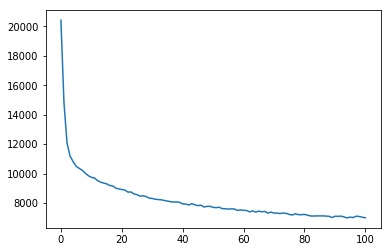

In [90]:
Loss_sn = []
B = 64 # batch size

# Loss b4 training
with torch.no_grad():
    running_loss = 0.0
    for i, data in enumerate(trainloader_L2L, 0):
        # get the inputs
        inputs = data['input']
        labels = data['output']
        outputs = rho_L_net(phi_L_net(inputs[:, :6]))
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    for i, data in enumerate(trainloader_S2S, 0):
        # get the inputs
        inputs = data['input']
        labels = data['output']
        outputs = rho_S_net(phi_S_net(inputs[:, :6]))
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    for i, data in enumerate(trainloader_L2S, 0):
        # get the inputs
        inputs = data['input']
        labels = data['output']
        outputs = rho_S_net(phi_L_net(inputs[:, :6]))
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    for i, data in enumerate(trainloader_S2L, 0):
        # get the inputs
        inputs = data['input']
        labels = data['output']
        outputs = rho_L_net(phi_S_net(inputs[:, :6]))
        loss = criterion(outputs, labels)
        running_loss += loss.item()        
    Loss_sn.append(running_loss)
    print('Initial loss:' + str(running_loss))
    
for epoch in range(150):  # loop over the dataset multiple times
    running_loss = 0.0
    mixed = []
    count_L2L = 0
    count_S2S = 0
    count_L2S = 0
    count_S2L = 0
    for i, data in enumerate(trainloader_L2L, 0):
        count_L2L += 1
        mixed.append(data)
    for i, data in enumerate(trainloader_S2S, 0):
        count_S2S += 1
        mixed.append(data)
    for i, data in enumerate(trainloader_L2S, 0):
        count_L2S += 1
        mixed.append(data)
    for i, data in enumerate(trainloader_S2L, 0):
        count_S2L += 1
        mixed.append(data)      
    shuffle(mixed)
    
    for data in mixed:
        # get the inputs
        inputs = data['input']
        labels = data['output']

        # zero the parameter gradients
        optimizer_phi_L.zero_grad()
        optimizer_rho_L.zero_grad()
        optimizer_phi_S.zero_grad()
        optimizer_rho_S.zero_grad()

        # forward + backward + optimize
        # L2L:0 S2S:1 L2S:2 S2L:3
        temp = torch.mean(inputs[:, 6]).item()
        temp = int(temp)
        if temp == 0:
            outputs = rho_L_net(phi_L_net(inputs[:, :6]))
            count_L2L -= 1
        elif temp == 1:
            outputs = rho_S_net(phi_S_net(inputs[:, :6]))
            count_S2S -= 1
        elif temp == 2:
            outputs = rho_S_net(phi_L_net(inputs[:, :6]))
            count_L2S -= 1
        elif temp == 3:
            outputs = rho_L_net(phi_S_net(inputs[:, :6]))
            count_S2L -= 1
        else:
            print('wrong class', temp)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_phi_L.step()
        optimizer_phi_S.step()
        optimizer_rho_L.step()
        optimizer_rho_S.step()
        
        # Lip
        for param in phi_L_net.parameters():
            M = param.detach().numpy()
            if M.ndim > 1:
                s = np.linalg.norm(M, 2)
                if s > 3.5:
                    param.data = param / s * 3.5
        for param in phi_S_net.parameters():
            M = param.detach().numpy()
            if M.ndim > 1:
                s = np.linalg.norm(M, 2)
                if s > 3.5:
                    param.data = param / s * 3.5
        for param in rho_L_net.parameters():
            M = param.detach().numpy()
            if M.ndim > 1:
                s = np.linalg.norm(M, 2)
                if s > 3.5:
                    param.data = param / s * 3.5
        for param in rho_S_net.parameters():
            M = param.detach().numpy()
            if M.ndim > 1:
                s = np.linalg.norm(M, 2)
                if s > 3.5:
                    param.data = param / s * 3.5
                    
        running_loss += loss.item()

    #if count_L2L != len(trainloader_L2L) or count_S2S != 2*len(trainloader_S2S) or count_L2S != len(trainloader_L2S) or count_S2L != len(trainloader_S2L):
    if count_L2L != 0 or count_S2S != 0 or count_L2S != 0 or count_S2S != 0:
        print('something goes wrong!')
        print(count_L2L, len(trainloader_L2L))
        print(count_S2S, len(trainloader_S2S))
        print(count_L2S, len(trainloader_L2S))
        print(count_S2L, len(trainloader_S2L))
        break
    Loss_sn.append(running_loss)
    if epoch % 2 == 0:
        print('[%d] loss: %.3f' % (epoch + 1, running_loss))

print('Finished Training')
plt.plot(Loss_sn)
plt.show()

In [91]:
# Loss after training
# L2L:0 S2S:1 L2S:2 S2L:3
train_loss_L2L = 0
train_loss_S2S = 0
train_loss_L2S = 0
train_loss_S2L = 0
with torch.no_grad():
    for i in range(len(trainset_L2L)):
        inputs = trainset_L2L[i]['input'] 
        label = trainset_L2L[i]['output']
        loss = criterion(rho_L_net(phi_L_net(inputs[:6])), label)
        train_loss_L2L += loss.item()
    for i in range(len(trainset_S2S)):
        inputs = trainset_S2S[i]['input'] 
        label = trainset_S2S[i]['output']
        loss = criterion(rho_S_net(phi_S_net(inputs[:6])), label)
        train_loss_S2S += loss.item()
    for i in range(len(trainset_L2S)):
        inputs = trainset_L2S[i]['input'] 
        label = trainset_L2S[i]['output']
        loss = criterion(rho_S_net(phi_L_net(inputs[:6])), label)
        train_loss_L2S += loss.item()
    for i in range(len(trainset_S2L)):
        inputs = trainset_S2L[i]['input'] 
        label = trainset_S2L[i]['output']
        loss = criterion(rho_L_net(phi_S_net(inputs[:6])), label)
        train_loss_S2L += loss.item()
        
print(train_loss_L2L / len(trainset_L2L))
print(train_loss_S2S / len(trainset_S2S))
print(train_loss_L2S / len(trainset_L2S))
print(train_loss_S2L / len(trainset_S2L))

8.34807902207657
1.5005867114575158
2.6370565779862063
12.105712919614248


In [92]:
torch.save(rho_L_net.state_dict(), 'rho_L_rw.pth')
torch.save(phi_L_net.state_dict(), 'phi_L_rw.pth')
torch.save(rho_S_net.state_dict(), 'rho_S_rw.pth')
torch.save(phi_S_net.state_dict(), 'phi_S_rw.pth')

# Learned $F_a$ visualization

**Heat map of 6-1 neural networks**

In [93]:
#rho_L_net.load_state_dict(torch.load('rho_L.pth'))
#rho_S_net.load_state_dict(torch.load('rho_S.pth'))
#phi_L_net.load_state_dict(torch.load('phi_L.pth'))
#phi_S_net.load_state_dict(torch.load('phi_S.pth'))

In [94]:
def heatmap(phi_net, rho_net, x_2=0, y_2=0, z_2=0.5, vx_2=0, vy_2=0, vz_2=0):
    z_min = 0.0
    z_max = 1.0
    y_min = -0.5
    y_max = 0.5
    
    z_length = int((z_max-z_min)*50) + 1
    y_length = int((y_max-y_min)*50) + 1
    
    z = np.linspace(z_max, z_min, z_length)
    y = np.linspace(y_min, y_max, y_length)
    
    fa_heatmap = np.zeros([1, z_length, y_length])
    
    for j in range(y_length):
        for i in range(z_length):
            c = np.zeros([1, 6])
            c[0, 0] = x_2 - 0
            c[0, 1] = y_2 - y[j]
            c[0, 2] = z_2 - z[i]
            c[0, 3] = vx_2
            c[0, 4] = vy_2
            c[0, 5] = vz_2
            cc = torch.from_numpy(c)
            with torch.no_grad():
                fa_heatmap[0, i, j] = rho_net(phi_net(cc[:, :6]))[0, 0].item() # f_a_z
    
    return y, z, y_2, z_2, fa_heatmap

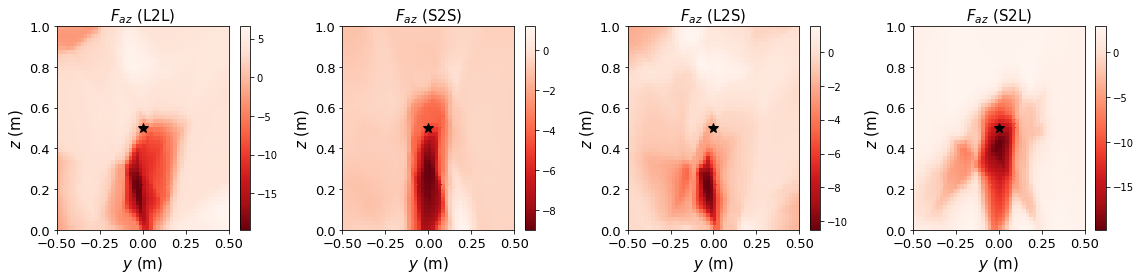

In [95]:
plt.figure(figsize=(16,4))
plt.subplot(1, 4, 1)
y, z, y_2, z_2, fa_heatmap = heatmap(phi_L_net, rho_L_net)
plt.ylabel(r'$z$ (m)', fontsize = 15)
plt.xlabel(r'$y$ (m)', fontsize = 15)
plt.title(r'${F_a}_z$ (L2L)', fontsize = 15)
plt.pcolor(y, z, fa_heatmap[0, :, :], cmap='Reds_r')
plt.colorbar()
plt.tick_params(labelsize = 13)
plt.plot([y_2], [z_2], marker='*', markersize=10, color="black")

plt.subplot(1, 4, 2)
y, z, y_2, z_2, fa_heatmap = heatmap(phi_S_net, rho_S_net)
plt.ylabel(r'$z$ (m)', fontsize = 15)
plt.xlabel(r'$y$ (m)', fontsize = 15)
plt.title(r'${F_a}_z$ (S2S)', fontsize = 15)
plt.pcolor(y, z, fa_heatmap[0, :, :], cmap='Reds_r')
plt.colorbar()
plt.tick_params(labelsize = 13)
plt.plot([y_2], [z_2], marker='*', markersize=10, color="black")

plt.subplot(1, 4, 3)
y, z, y_2, z_2, fa_heatmap = heatmap(phi_L_net, rho_S_net)
plt.ylabel(r'$z$ (m)', fontsize = 15)
plt.xlabel(r'$y$ (m)', fontsize = 15)
plt.title(r'${F_a}_z$ (L2S)', fontsize = 15)
plt.pcolor(y, z, fa_heatmap[0, :, :], cmap='Reds_r')
plt.colorbar()
plt.tick_params(labelsize = 13)
plt.plot([y_2], [z_2], marker='*', markersize=10, color="black")

plt.subplot(1, 4, 4)
y, z, y_2, z_2, fa_heatmap = heatmap(phi_S_net, rho_L_net)
plt.ylabel(r'$z$ (m)', fontsize = 15)
plt.xlabel(r'$y$ (m)', fontsize = 15)
plt.title(r'${F_a}_z$ (S2L)', fontsize = 15)
plt.pcolor(y, z, fa_heatmap[0, :, :], cmap='Reds_r')
plt.colorbar()
plt.tick_params(labelsize = 13)
plt.plot([y_2], [z_2], marker='*', markersize=10, color="black")
plt.tight_layout()
plt.show()

# Validation on some trajectory 

In [96]:
def Fa_prediction(data_input, phi_net, rho_net):
    L = len(data_input)
    Fa = np.zeros(L)
    for i in range(L):
        inputs = data_input[i, :6]
        Fa[i] = rho_net(phi_net(torch.from_numpy(inputs))).item()
    return Fa

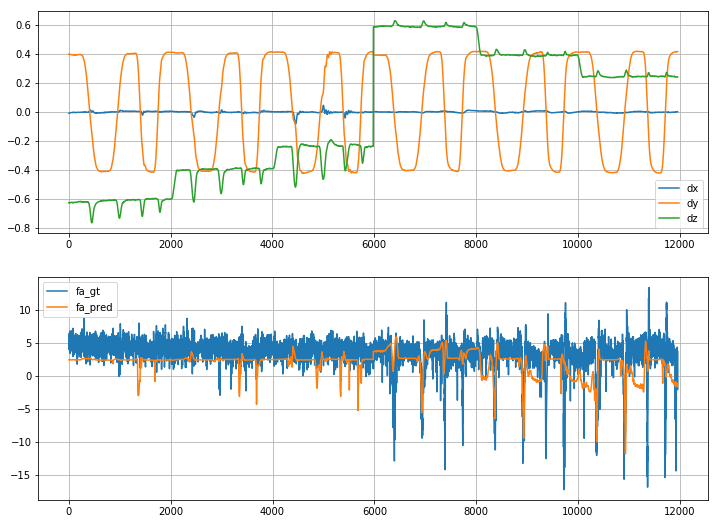

In [100]:
ss = 0
ee = -1
data_input = data_input_S2L_val[ss:ee, :]
data_output = data_output_S2L_val[ss:ee, :]
Fa_pred = Fa_prediction(data_input, phi_S_net, rho_L_net)
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.plot(data_input[:, :3])
plt.legend(['dx', 'dy', 'dz'])
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(data_output[:, 2])
plt.hlines(y=0, xmin=0, xmax=ee-ss, colors='r')
plt.plot(Fa_pred)
plt.legend(['fa_gt', 'fa_pred'])
plt.grid()
plt.show()